In [ ]:
!pip install transformers --quiet
!pip install opendatasets --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: klaus2twarz2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 723MB/s]

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


wczytanie danych

In [ ]:
data_df = pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines = True)

data_df.dropna(inplace=True) #usun wiersze z NAN
data_df.drop_duplicates(inplace=True)
data_df.drop(['article_link'], inplace=True, axis = 1)
print(data_df.shape)
data_df.head()

(26708, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


podzial danych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df['is_sarcastic']), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

#train 0.7, test 0.15, val 0.15
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(18695,)
(4007,)
(4006,)


wcyztanie modelu i tokenizacji tekstu

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tworzenie Dataset

original -> ["Leci bocian nad jeziorem"]

tokens -> [423, 444, 232, 3, max_lenght 100 wiec, 0 ,0 ,0 ,0, 0 ....] size = 100 musi

In [ ]:
class dataset(Dataset):
  def __init__(self, X, Y):
      # konstruktor przyjmuje dane wejściowe X (teksty) i Y (etykiety)
    self.X = [tokenizer(x,                       # tokenizujemy każdy tekst x w X
                        max_length=100,         # maksymalna długość sekwencji to 100 tokenów
                        truncation=True,        # ucinamy teksty dłuższe niż 100 tokenów
                        padding="max_length",   # dodajemy padding do tekstów krótszych niż 100 tokenów
                        return_tensors='pt')    # zwracamy dane w formacie tensora PyTorch
                        .to(device)             # przenosimy tokeny bezpośrednio na GPU lub CPU (np. cuda / mps / cpu)
                        for x in X]             # wykonujemy to dla każdego x w liście X



    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

In [ ]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

paramtery

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

dataloader

In [ ]:
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

budowa modelu

In [ ]:
class TextModel(nn.Module):
  def __init__(self, bert_model): #dziedziczymy po bert_model
    super(TextModel, self).__init__()

    self.bert_model = bert_model
    self.dropout = nn.Dropout(0.25)
    self.linear1 = nn.Linear(768, 384) #nasz bert wypluwa size 768 dlatego tutaj zaczyanmy od tylu
    self.linear2 = nn.Linear(384, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    # Przepuszczamy dane wejściowe (input_ids i attention_mask) przez model BERT
    # return_dict=False sprawia, że BERT zwróci tuple zamiast słownika
    # [0] to "last hidden states", a [:, 0] wybiera pierwszy token (czyli [CLS] embedding)
    pooled_output = self.bert_model(input_ids, attention_mask, return_dict=False)[0][:, 0] #bert-base-*	size -> 768 dltageo linear zaczynamy od tylu

    # Przepuszczamy wektor [CLS] przez pierwszą warstwę liniową (np. redukcja wymiaru)
    output = self.linear1(pooled_output)

    # Nakładamy dropout – chroni przed overfittingiem w trakcie treningu
    output = self.dropout(output)

    # Przepuszczamy przez drugą warstwę liniową – zwykle końcowa warstwa klasyfikująca
    output = self.linear2(output)

    # Nakładamy aktywację sigmoid – przekształca wynik do przedziału (0,1)
    # Używane np. do klasyfikacji binarnej (jeden neuron na wyjściu)
    output = self.sigmoid(output)

    # Zwracamy końcowy wynik predykcji (prawdopodobieństwo klasy)
    return output



In [ ]:
# 🔒 Zamrażamy wszystkie warstwy BERT-a — nie będą trenowane (gradienty nie będą liczone)
for param in bert_model.parameters(): # będziemy zmieniac tylko nasze warstwy a oryginal zostaje
    param.requires_grad = False

# 📦 Tworzymy nasz model klasyfikacyjny (TextModel), przekazując zamrożony model BERT jako ekstraktor cech
# i przenosimy cały model na odpowiednie urządzenie (CPU lub GPU)
model = TextModel(bert_model).to(device)



In [ ]:
model

TextModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
criterion = nn.BCELoss() #bo binarna klasyfikacja
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = [] #strata
total_loss_val_plot = []
total_acc_train_plot = [] #dokładność
total_acc_val_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0.0
  total_acc_train = 0.0
  total_loss_val = 0.0
  total_acc_val = 0.0

  for batch_idx, (inputs, labels) in enumerate(train_loader):
    optimizer.zero_grad()

    inputs.to(device)
    labels.to(device)

    prediction = model(inputs['input_ids'].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)

    train_loss = criterion(prediction, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    acc = ((prediction).round() == labels).sum().item()
    total_acc_train +=acc

    optimizer.step()

  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data
      prediction = model(inputs['input_ids'].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
      val_loss = criterion(prediction, labels)
      total_loss_val += val_loss.item()

      acc = ((prediction).round() == labels).sum().item()
      total_acc_val +=acc


  fin_total_loss_train = round(total_loss_train /1000, 4)
  fin_total_loss_val = round(total_loss_val /1000, 4)
  fin_total_acc_train = round(total_acc_train /training_data.__len__() * 100, 4) #tutaj procentu np mamy 6 popawnych z 10 i to procnt. len daje nam dlugosc danych
  fin_total_acc_val = round(total_acc_val /validation_data.__len__() * 100, 4)


  total_loss_train_plot.append(fin_total_loss_train)
  total_loss_val_plot.append(fin_total_loss_val)
  total_acc_train_plot.append(fin_total_acc_train)
  total_acc_val_plot.append(fin_total_acc_val)

  print(f'''Epoch no. {epoch + 1}/{EPOCHS} Train Loss: {fin_total_loss_train} Train Accuracy: {fin_total_acc_train} Validation Loss: {fin_total_loss_val} Validation Accuracy: {fin_total_acc_val}''')
  print("="*25)


Epoch no. 1/10 Train Loss: 0.208 Train Accuracy: 84.8302 Validation Loss: 0.0456 Validation Accuracy: 84.698
Epoch no. 2/10 Train Loss: 0.1971 Train Accuracy: 85.3383 Validation Loss: 0.0432 Validation Accuracy: 85.4468
Epoch no. 3/10 Train Loss: 0.1898 Train Accuracy: 86.2584 Validation Loss: 0.0425 Validation Accuracy: 85.6465
Epoch no. 4/10 Train Loss: 0.1869 Train Accuracy: 86.3653 Validation Loss: 0.0425 Validation Accuracy: 85.4468
Epoch no. 5/10 Train Loss: 0.1833 Train Accuracy: 86.6435 Validation Loss: 0.0429 Validation Accuracy: 85.1972
Epoch no. 6/10 Train Loss: 0.1811 Train Accuracy: 86.7612 Validation Loss: 0.0424 Validation Accuracy: 85.8712
Epoch no. 7/10 Train Loss: 0.1803 Train Accuracy: 86.8895 Validation Loss: 0.0414 Validation Accuracy: 85.6216
Epoch no. 8/10 Train Loss: 0.178 Train Accuracy: 87.0179 Validation Loss: 0.0417 Validation Accuracy: 85.8462
Epoch no. 9/10 Train Loss: 0.1767 Train Accuracy: 87.0286 Validation Loss: 0.0413 Validation Accuracy: 86.1208
Epoc

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for batch_idx, (inputs, labels) in enumerate(test_loader):
    inputs.to(device)
    labels.to(device)

    prediction = model(inputs['input_ids'].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)

    train_loss = criterion(prediction, labels)
    total_loss_test += train_loss.item()

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test +=acc

fin_total_loss_test = round(total_loss_test /1000, 4)
fin_total_acc_test = round(total_acc_test /testing_data.__len__() * 100, 4)

print("Accuracy: ", fin_total_acc_test)

Accuracy:  85.8248


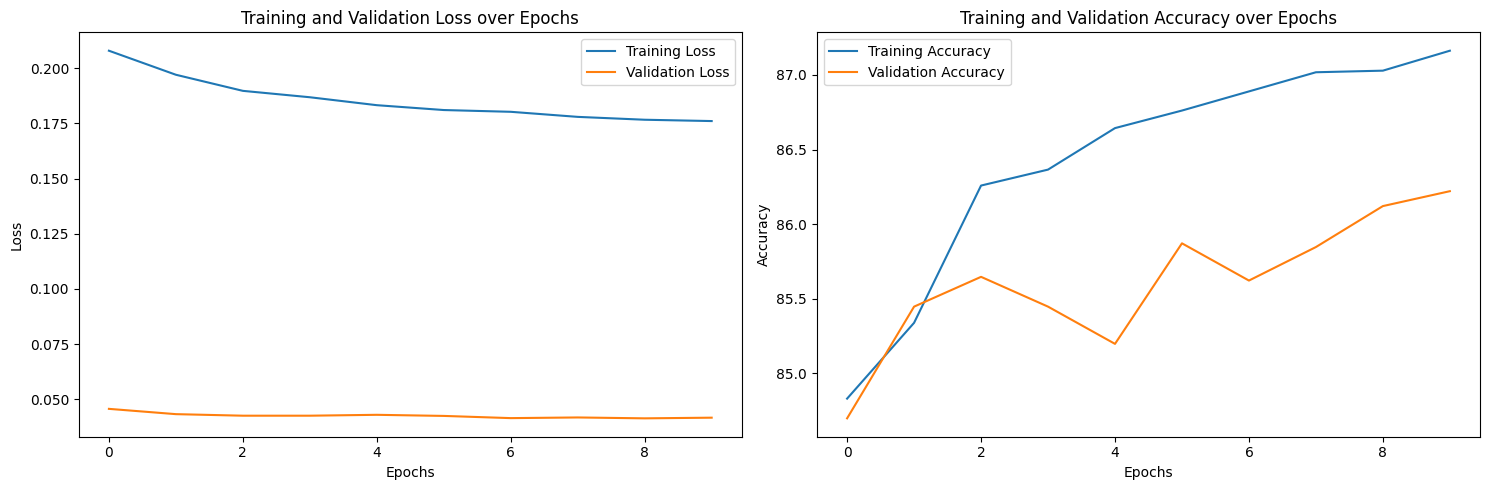

In [ ]:
ig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
#axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
#axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

test modelu na moim słowie

In [ ]:
def pred_text(text):
  model.eval()   # tryb testowy – bardzo ważny!

  token = [tokenizer(text,
                    max_length=100,
                    truncation=True,
                    padding="max_length",
                    return_tensors='pt')]
  token = token[0]

  input_ids = token['input_ids'].to(device)
  attention_mask = token['attention_mask'].to(device)

  with torch.no_grad():
    output = model(input_ids, attention_mask).squeeze(0)  # → tensor
    prob = output.item()  # konwertujemy do float

  label = 1 if prob >= 0.5 else 0

  print(f"Prawdopodobieństwo klasy pozytywnej: {prob:.4f}")
  print(f"Predykcja: {label} ({'Pozytywna' if label == 1 else 'Negatywna'})")


In [ ]:
text = "Robert Kubica should be in Formula 1"

pred_text(text)

Prawdopodobieństwo klasy pozytywnej: 0.1053
Predykcja: 0 (Negatywna)
